<a href="https://colab.research.google.com/github/ARBasharat/AudioClassification/blob/master/AudioClassification2D_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

abbash@iu.edu <br/>
Audio Spectrogram Classification using LSTM <br/>

# Load Libraries

In [1]:
import os
import random
import time
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
from scipy import signal

# Read Data from Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

train = np.load("drive/My Drive/AudioClassification/audio_train.npy").astype('float32')
test = np.load("drive/My Drive/AudioClassification/audio_test.npy").astype('float32')
train_labels_df = pd.read_csv("drive/My Drive/AudioClassification/labels_train.csv")


Mounted at /content/drive


# Process the data

In [5]:
train_labels = train_labels_df.to_numpy()[:,1]
labels_categorical = keras.utils.to_categorical(train_labels)
X_train_original, X_val_original, y_train_original, y_val = train_test_split(train, 
                          labels_categorical, test_size=0.20, random_state=42)

print("Training Data:", X_train_original.shape)
print("Training Labels:", y_train_original.shape)
print("Validation Data:", X_val_original.shape)
print("Validation Labels:", y_val.shape)
print("Testing Data:", test.shape)

Training Data: (753, 30000)
Training Labels: (753, 10)
Validation Data: (189, 30000)
Validation Labels: (189, 10)
Testing Data: (558, 30000)


In [6]:
## We switch between white and normal noise randomly

def add_white_noise(data, rate = 0.05):
  data_with_white_noise = data + rate * np.random.randn(len(data))
  return data_with_white_noise

'''
Noise addition using normal distribution with mean = 0 and std =1
Permissible noise factor value = x > 0.004
'''
def add_normal_distributed_noise(data, rate = 0.09, sr = 30000):
  data_with_noramlized_noise = data + rate * np.random.normal(0, 1, len(data))
  return data_with_noramlized_noise

'''
Time Shifting
Permissible factor values = sr/10
'''
def add_time_shift(data, sr = 30000):
  data_with_time_shift = np.roll(data, int(sr/10))
  return data_with_time_shift

'''
Time Stretching
Permissible factor values = 0 < x < 1.0
'''
def add_time_stretch(data, factor = 0.8):
  data_with_time_strect = librosa.effects.time_stretch(data, factor)
  return data_with_time_strect


'''
Pitch shifting
Permissible factor values = -5 <= x <= 5
'''
def add_pitch_shift(data, sr = 30000, steps = -7):
  data_with_pitch_shift = librosa.effects.pitch_shift(data, sr, n_steps = steps)
  return data_with_pitch_shift

In [7]:
# Get augmented_training data equal to size of real data
def get_augmented_data_two_times(X_train_original, y_train_original):
  new_data = []
  new_labels = []
  for i in range(0, len(X_train_original)):
    data = X_train_original[i]
    label = y_train_original[i]
    choice = random.choice([1, 2, 3, 4, 5]) ## Used for selecting between white noise and normalized noise
    ## get augmented data
    new_data.append(data)
    if choice == 1:
      new_data.append(add_white_noise(data))
    elif choice == 2:
      new_data.append(add_normal_distributed_noise(data))
    elif choice == 3:
      new_data.append(add_time_shift(data))
    elif choice == 4:
      new_data.append(add_time_stretch(data))
    elif choice == 5:
      new_data.append(add_pitch_shift(data))
    ## get labels
    new_labels.append(label)
    new_labels.append(label)

  ## Shuffle data
  compressed = list(zip(new_data, new_labels))
  random.shuffle(compressed)
  new_data, new_labels = zip(*compressed)

  ## Get augmented train data and labels
  train_data = np.array(new_data)
  y_train = np.array(new_labels)
  return train_data, y_train

train_data, y_train = get_augmented_data_two_times(X_train_original, y_train_original)
print(train_data.shape, y_train.shape)

(1506,) (1506, 10)


In [21]:
def get_spectrogram(in_data):
  spectrogram = []
  for elem in in_data:
    converted = librosa.stft(elem)
    spectrum, _ = librosa.magphase(converted)
    spectrum = np.abs(spectrum).astype(np.float32)
    norm = spectrum.max()
    spectrum /= norm
    result = np.zeros((spectrum.shape[0], 74))
    result[:spectrum.shape[0],:spectrum.shape[1]] = spectrum
    result = result.reshape((result.shape[0], result.shape[1]))
    spectrogram.append(result)
  spectrogram = np.array(spectrogram)
  return spectrogram

In [25]:
X_train = get_spectrogram(train_data)
X_val = get_spectrogram(X_val_original)
X_test = get_spectrogram(test)

print("Train Shape: ", X_train.shape, y_train.shape)
print("Validation Shape: ", X_val.shape, y_val.shape)
print("Test Shape: ", X_test.shape)

Train Shape:  (1506, 1025, 74) (1506, 10)
Validation Shape:  (189, 1025, 74) (189, 10)
Test Shape:  (558, 1025, 74)


In [41]:
def plot_performance_curves(history):
  #  "Accuracy"
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

# Train LTSM Model

In [34]:
def get_model(X_train):
  model = keras.models.Sequential()
  model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True), 
                        input_shape=X_train[0].shape))
  model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(400))
  model.add(layers.ELU())
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(10, activation='softmax'))
  return model 

In [35]:
model = get_model(X_train)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(0.005, beta_1=0.1, beta_2=0.001, amsgrad=True),
              metrics=['acc'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, batch_size=64, epochs=200,
          verbose=2, validation_data=(X_val, y_val), callbacks=callback)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, 1025, 512)         677888    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 1025, 512)         1574912   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1025, 512)         0         
_________________________________________________________________
dense_11 (Dense)             (None, 1025, 400)         205200    
_________________________________________________________________
elu_6 (ELU)                  (None, 1025, 400)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1025, 400)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 410000)           

6/6 [==============================] - 1s 99ms/step - loss: 0.2437 - acc: 0.9259


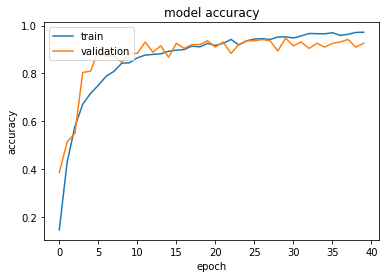

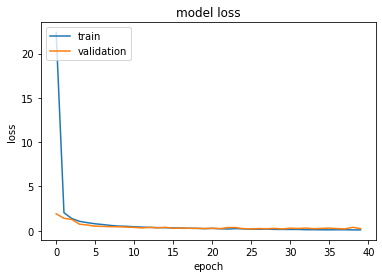

In [42]:
model.evaluate(X_val, y_val)
plot_performance_curves(history)

In [44]:
predictions = model.predict(X_test)
prediction_classes = model.predict_classes(X_test)
prediction_classes

array([5, 9, 4, 1, 4, 5, 9, 3, 3, 7, 7, 3, 1, 8, 0, 7, 7, 3, 5, 3, 3, 3,
       9, 6, 3, 5, 7, 7, 0, 4, 4, 1, 3, 1, 6, 3, 1, 3, 9, 9, 0, 1, 5, 9,
       4, 7, 3, 3, 3, 6, 9, 6, 0, 0, 8, 3, 5, 6, 3, 3, 3, 7, 8, 7, 0, 0,
       4, 6, 3, 3, 3, 4, 3, 5, 1, 4, 9, 7, 1, 5, 0, 1, 6, 9, 7, 3, 3, 3,
       1, 6, 0, 8, 0, 8, 7, 7, 3, 3, 6, 6, 0, 3, 7, 3, 7, 3, 3, 4, 1, 3,
       3, 3, 7, 7, 1, 9, 9, 4, 5, 1, 5, 9, 3, 4, 3, 3, 7, 3, 0, 3, 8, 7,
       3, 3, 3, 6, 7, 3, 5, 4, 1, 1, 4, 8, 7, 3, 3, 3, 1, 5, 0, 9, 5, 3,
       3, 9, 3, 9, 4, 0, 3, 6, 0, 7, 3, 7, 7, 3, 5, 0, 4, 0, 8, 8, 6, 3,
       7, 3, 6, 5, 5, 1, 0, 7, 6, 1, 0, 1, 3, 3, 9, 6, 1, 4, 8, 8, 4, 5,
       7, 6, 7, 5, 7, 1, 6, 6, 9, 9, 6, 3, 3, 9, 5, 9, 1, 7, 0, 5, 1, 1,
       9, 3, 3, 3, 6, 4, 8, 5, 8, 9, 7, 3, 3, 7, 5, 8, 6, 8, 3, 3, 6, 9,
       6, 9, 4, 5, 0, 7, 9, 3, 9, 3, 3, 8, 0, 5, 8, 7, 7, 6, 7, 3, 7, 3,
       3, 3, 5, 1, 5, 8, 6, 9, 3, 3, 3, 7, 9, 0, 9, 1, 1, 5, 1, 7, 3, 9,
       3, 8, 7, 3, 0, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8,

In [45]:
import collections
counter=collections.Counter(prediction_classes)
print(counter)

Counter({3: 164, 7: 68, 1: 59, 6: 50, 9: 48, 4: 48, 8: 43, 5: 42, 0: 36})


In [46]:
pd.DataFrame(prediction_classes).to_csv("submission.csv")